<a href="https://colab.research.google.com/github/Shady-Rouk/Disaster-Tweet-Classifier/blob/main/TechExchange_2023_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction




####Project Overview
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example: "Look at the sky last night, it was ablaze"


The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially if the tweet includes a visual aid. But it’s less clear to a machine.

We are trying to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have access to a dataset of 10,000 tweets that were hand classified.

####Data
We are given a train.csv, test.csv and sample_submission.csv.

Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)

**What are we predicting?**
We are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**Columns**

id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

####Tasks
We are trying to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

####Challenges
1. Generate a baseline. Split the training data into 90% for training and 10% for validation
2. Data Analysis: Have at least 2 different methods for learning about the data and understanding the differences between the classes.
This can include visualization like histograms or tables/lists of features and their counts in each class, for example.
The goal of data analysis is to help you understand the task more deeply.
3. Train Tensorflow models to correctly make predictions on the test data.
4. Analyze possible errors made by the models trained.

In [ ]:
# Import our standard libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns # for nicer plots
sns.set(style='darkgrid') #default style
import tensorflow as tf
import sklearn.metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data for Sentiment Classification

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Machine Learning Final Project/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Machine Learning Final Project/test.csv')

In [ ]:
display(train_df[:10])

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


We will shuffle the current data so that the train-validation split is more consistent with both positive and negative examples.

In [ ]:
# shuffle the train data then split for validation
np.random.seed(0)
train_df_shuffled = train_df.reindex(np.random.permutation(train_df.shape[0]))
display(train_df_shuffled[:10])

,id,keyword,location,text,target
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit g...,0
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...,0
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Presea...,0
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...,0
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...,0
3074,4410,electrocute,Naperville,Electrocute yourself,0
1833,2635,crashed,Lindenhurst,Thief Broke Front Window Of Hicksville Store S...,0
2272,3259,demolish,Eastbourne England,Doone Silver Architects has won permission to ...,0
1234,1775,buildings%20on%20fire,"Manchester, NH",Fire destroys two buildings on 2nd Street in #...,1
1326,1917,burning,[ kate + they/them + infp-t ],@minsuwoongs i completely understand because i...,0


In [ ]:
#Note: 90 percent of 7613 is approximately 6852
shuffled_train = train_df_shuffled[:6852]
shuffled_validation = train_df_shuffled[6852:]

features = ["id", "keyword", "location", "text"]

train_features = shuffled_train[features]
train_labels = shuffled_train["target"]

validate_features = shuffled_validation[features]
validate_labels = shuffled_validation["target"]

print("Train feature shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Validate feature shape:", validate_features.shape)
print("Validate labels shape:", validate_labels.shape)

display(train_features[:5])

Train feature shape: (6852, 4)
Train labels shape: (6852,)
Validate feature shape: (761, 4)
Validate labels shape: (761,)


,id,keyword,location,text
311,454,armageddon,Wrigley Field,@KatieKatCubs you already know how this shit g...
4970,7086,meltdown,Two Up Two Down,@LeMaireLee @danharmon People Near Meltdown Co...
527,762,avalanche,Score Team Goals Buying @,1-6 TIX Calgary Flames vs COL Avalanche Presea...
6362,9094,suicide%20bomb,Roadside,If you ever think you running out of choices i...
800,1160,blight,Laventillemoorings,If you dotish to blight your car go right ahea...


## Calculating F1 Score
Our model will be evaluated using F1 between the predicted and expected answers. F1 is calculated as:
$$F_1 = 2 * \frac{precision*recall}{precision+recall}$$
where:
$$precision = \frac{TP}{TP+FP}$$
$$recall = \frac{TP}{TP+FN}$$

In [ ]:
# Takes in true labels and model predictions, and returns the F1 score
def calculate_f1_score(Y_true, Y_pred):
  TP, TN, FP, FN = 0, 0, 0, 0
  for pred, true_val in zip(Y_pred, Y_true):
    if pred == 1 and true_val == 1:
      TP += 1
    elif pred == 0 and true_val == 0:
      TN += 1
    elif pred == 1 and true_val == 0:
      FP += 1
    elif pred == 0 and true_val == 1:
      FN += 1
  precision = TP/(TP + FP)
  recall = TP/(TP + FN)
  score = 2 * (precision * recall) / (precision + recall)
  return score

## Baseline Model
For our baseline model, we have set up a list of common words that can be associated with a disaster. For each example in the training dataset, we check if the text value contains any of the words in our predetermined list and if the number of characters in the text is greater than 40. If it meets both conditions, the prediction is positive, else negative.

In [ ]:
# Predetermined list of words that may be associated with disasters
names = ["fire", "flood", "smok", "emergency", "rain", "ablaze", "burning", "accident", "disaster", "crash", "dead", "death", "die", "rest",
 "kill", "annihilat", "fight", "attack", "arson", "bomb", "avalanch", "bleed", "landslide", "wav", "cyclon", "hail", "pandemic", "drought", "traged",
 "calamit", "mishap", "blast", "injury", "catastroph", "casualt", "blow", "bump", "wreckag", "assault",
  "murder", "assassinat", "drown", "execut", "obliterate", "slaughter", "poison", "electrocut", "eradicat", "destroy", "desolated", "desolating",
  "risk", "disrupt", "colli", "derail", 'debris', "demoli", "delug", "debris", "suicide", "wildfire", "typhoon-devastated", "violent", "severe",
  "suffer", "shot", "shoot", "earthquake", "terrorism", "horror", "famine", "fear", "flame", "hazard", "hailstorm", "hellfire", "hostage"
  ]

#predicting a sentence is about a disaster if it has at least one of the words in names and has a length of at least 41.
def baseline(input_features):
  preds = []
  for row in input_features.iterrows():
    sentence = row[1]["text"].lower()
    gotten = False
    for word in names:
      if word in sentence and len(sentence) > 40:
        preds.append(1)
        gotten = True
        break
    if not gotten:
      preds.append(0)
  return preds

In [ ]:
# Getting predictions from the baseline model on training data and validation data
Y_preds = baseline(train_features)
Y_validate_preds = baseline(validate_features)

# Evaluating the baseline predictions on training and validation data using F1
print(calculate_f1_score(train_labels, Y_preds))
print(calculate_f1_score(validate_labels, Y_validate_preds))

0.6229709035222053
0.6582278481012659


In [ ]:
# Making baseline predictions on the test data
test_preds = baseline(test_df)
result = test_df["id"]
result = pd.DataFrame(result)
result["target"] = test_preds
display(result)

# Writing predictions to csv file.
result.to_csv('submission.csv', index=False)

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


Baseline Score on Validation Data: 0.6582278481012659

Baseline Score on Test Data from LeaderBoard: 0.63499

## Data Analysis

We will start the data analysis by checking how long the tweets are when they're talking about a disaster vs when they are not. We are trying to see if this would give any distinction between disaster tweets and non-disaster tweets.

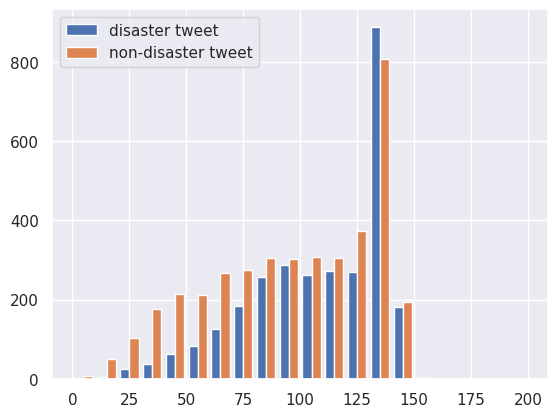

Longest disaster tweet: 151
Longest non-disaster tweet: 157
(6852,)
(6852,)
(761,)
(761,)
@KatieKatCubs you already know how this shit goes. World Series or Armageddon.


In [ ]:
X_train, Y_train = np.array(train_features["text"]), np.array(train_labels)
X_validate, Y_validate = np.array(validate_features["text"]), np.array(validate_labels)

# Create a list of lengths for training examples with a positive label.
text_lengths_disaster = [len(x) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of lengths for training examples with a negative label.
text_lengths_non_disaster = [len(x) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_disaster, text_lengths_non_disaster], bins=20, range=(0, 200),
         label=['disaster tweet', 'non-disaster tweet'])
plt.legend()
plt.show()

# Also check the longest tweets.
print('Longest disaster tweet:', max(text_lengths_disaster))
print('Longest non-disaster tweet:', max(text_lengths_non_disaster))

print(X_train.shape)
print(Y_train.shape)
print(X_validate.shape)
print(Y_validate.shape)
print(X_train[0])

From the histogram, we can see that both disaster tweets and non disaster tweets have sentence length of almost all sizes. However, most of the time, non-disaster tweets are more occuring except in sentence length between 125 and 150 where disaster tweets take over.

We then decided to move to checking how many words are in tweets talking about disasters vs non-disasters.

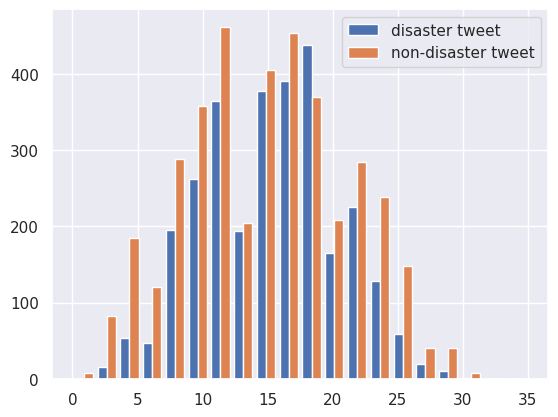

Max words in a disaster tweet: 30
Max words in a non-disaster tweet: 31


In [ ]:
# Create a list of number of words for training examples with a positive label.
word_count_disaster = [len(x.split()) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of number of words for training examples with a negative label.
word_count_non_disaster = [len(x.split()) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([word_count_disaster, word_count_non_disaster], bins=20, range=(0, 35),
         label=['disaster tweet', 'non-disaster tweet'])
plt.legend()
plt.show()

# Also check the maximum word count in tweets.
print('Max words in a disaster tweet:', max(word_count_disaster))
print('Max words in a non-disaster tweet:', max(word_count_non_disaster))

Just like when checking the length of sentence, both disaster and non-disaster tweets occur in all word ranges with more in non-disaster tweets.

We finally decided to examine the number of times words from the `keyword` column in the training dataset appear in disaster tweets and non-disaster tweets.

In [ ]:
keywords = np.array(train_features["keyword"])

def get_counts(token):
  token_idx = [i for i in range(len(X_train)) if token.lower() in X_train[i].lower()]
  token_labels = Y_train[token_idx]
  pos_count = token_labels[token_labels == 1]
  neg_count = token_labels[token_labels == 0]
  return pos_count.size, neg_count.size

pos_dict = {}
neg_dict = {}

for word in keywords:
  word = str(word)
  word = word.lower()
  if "%20" in word:
    word = word.replace("%20", " ")
  pos, neg = get_counts(word)
  pos_dict[word] = pos
  neg_dict[word] = neg

print(pos_dict)
print(neg_dict)

{'armageddon': 4, 'meltdown': 6, 'avalanche': 4, 'suicide bomb': 84, 'blight': 2, 'electrocute': 12, 'crashed': 23, 'demolish': 13, 'buildings on fire': 6, 'burning': 57, 'quarantined': 11, 'natural disaster': 15, 'exploded': 9, 'deluge': 11, 'evacuate': 50, 'chemical emergency': 0, 'destroy': 32, 'smoke': 10, 'refugees': 28, 'suicide bomber': 56, 'ruin': 4, 'survivors': 27, 'injuries': 17, 'nan': 12, 'trouble': 3, 'twister': 6, 'body bag': 5, 'bombing': 66, 'emergency plan': 14, 'demolition': 9, 'weapon': 37, 'rioting': 22, 'inundation': 1, 'accident': 64, 'annihilated': 8, 'curfew': 5, 'dead': 65, 'collapsed': 11, 'fatality': 8, 'rubble': 9, 'survived': 14, 'thunder': 61, 'trapped': 11, 'danger': 12, 'wounded': 26, 'displaced': 26, 'destruction': 11, 'drown': 24, 'devastation': 24, 'bridge collapse': 18, 'famine': 25, 'drowned': 11, 'detonate': 40, 'police': 88, 'upheaval': 5, 'fire truck': 8, 'panicking': 2, 'wounds': 11, 'traumatised': 3, 'apocalypse': 8, 'casualty': 15, 'violent s

In [ ]:
word_frequency = pd.DataFrame({'keyword': list(pos_dict.keys()),
                   'positive_count': list(pos_dict.values()),
                   'negative_count': list(neg_dict.values())})
# display(word_frequency)

word_freq_by_pos = word_frequency.sort_values('positive_count', ascending=False)
word_freq_by_neg = word_frequency.sort_values('negative_count', ascending=False)

# ordering keywords by the number of times they occurred in positive and negative examples
display(word_freq_by_pos[['keyword', 'positive_count']][:15])
display(word_freq_by_neg[['keyword', 'negative_count']][:15])

,keyword,positive_count
127,fire,310
134,storm,213
69,bomb,192
81,flood,98
180,crash,93
131,attack,91
194,disaster,89
53,police,88
3,suicide bomb,84
206,fatal,82


,keyword,negative_count
127,fire,121
134,storm,96
97,emergency,72
26,body bag,69
98,blood,66
47,drown,63
77,panic,60
93,wreck,59
16,destroy,54
80,crush,53


From the keyword frequency value table, we noticed that there are keywords that appear in both disaster tweets (positive) and non-disaster tweets (negative). However, some keywords are more likely to appear in a disaster tweet than a non-disaster tweet. For example, `fire` is the keyword that appears the most in the training data, but it appears in more positive examples than negative examples.

## Building Vocabulary and Transforming Data

In [ ]:
max_sequence_length = 32

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=None, # Maximum vocabulary size (None -> no cap)
    standardize='lower_and_strip_punctuation', # Standarization to apply to text (None -> no standarization)
    split='whitespace', # Values can be None (no splitting), "whitespace", or a Callable
    output_mode='int',  # Values can be "int", "multi_hot", "count" or "tf_idf"
    output_sequence_length=max_sequence_length, # Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values
    )

vectorize_layer.adapt(X_train)
vocab = dict(enumerate(vectorize_layer.get_vocabulary()))
max_id = max(vocab.keys())
print('Largest ID:', max_id)

# 0: ('') - Padding Token
# 1: ('[UNK]') - OOV Token

Largest ID: 21030


In [ ]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [vocab.get(i, "[UNK]") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

In [ ]:
# This has accounted for special chacters and punctuation in text before vectorizing.
X_train_vectorized = vectorize_layer(X_train)
X_validate_vectorized = vectorize_layer(X_validate)


print(X_train_vectorized[0])
print(decode(np.array(X_train_vectorized[0])))

tf.Tensor(
[11708    12   551    90    61    19   210   568   102  1041    55   405
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(32,), dtype=int64)
katiekatcubs you already know how this shit goes world series or armageddon                    


## Training Models

#### Padding the Training Data

As is clear from the histogram, the number of words in a tweet is variable. Since fixed-length arrays are easier to work with in Tensorflow, let's add special padding tokens at the end of each tweet until they are all the same length.

We'll also use this operation to limit the number of token positions by truncating all tweets to a specified length. In the code below, as an example, we pad all training inputs to length 25 words.


In [ ]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

X_train_padded = pad_data(X_train_vectorized, max_length=25)
X_validate_padded = pad_data(X_validate_vectorized, max_length=25)


#### Reducing the Vocabulary

We also want to be able to limit the vocabulary size. Since our padding function produces fixed-length sequences in a numpy matrix, we can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

In the code below, as an example, we'll keep just token ids less than 1500, replacing all others with OOV.

In [ ]:
def limit_vocab(sequences, max_token_id, oov_id=1):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

X_train_reduced = limit_vocab(X_train_padded, max_token_id=1500)
X_validate_reduced = limit_vocab(X_validate_padded, max_token_id=1500)

# Create a one-hot encoding for the training data.
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
X_validate_one_hot = tf.keras.utils.to_categorical(X_validate_reduced, num_classes=1500)

print(X_train_one_hot.shape)
print(X_validate_one_hot.shape)

(6852, 25, 1500)
(761, 25, 1500)


####Feed Forward Neural Network with One-Hot Encodings by Averaging

Flatten by averaging over token positions. The result is an array with average token counts, ignoring position.

In [ ]:
def build_onehot_model():
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(0)

  model = tf.keras.Sequential()
  # This layer averages over the first dimension of the input by default.
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(
      units=10,
      activation='relu'
  ))
  model.add(tf.keras.layers.Dense(
      units=128,
      activation='relu'
  ))
  model.add(tf.keras.layers.Dense(
      units=18,
      activation='sigmoid'
  ))
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])
  return model

Now let's try fitting the model to our training data and check performance metrics on the validation (held-out) data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

Epoch 1/5
108/108 [==============================] - 4s 18ms/step - loss: 0.6846 - accuracy: 0.5699 - val_loss: 0.6813 - val_accuracy: 0.5742
Epoch 2/5
108/108 [==============================] - 1s 12ms/step - loss: 0.6755 - accuracy: 0.5708 - val_loss: 0.6622 - val_accuracy: 0.5861
Epoch 3/5
108/108 [==============================] - 1s 9ms/step - loss: 0.6256 - accuracy: 0.6745 - val_loss: 0.6065 - val_accuracy: 0.7030
Epoch 4/5
108/108 [==============================] - 1s 9ms/step - loss: 0.5554 - accuracy: 0.7345 - val_loss: 0.5703 - val_accuracy: 0.7109
Epoch 5/5
108/108 [==============================] - 1s 10ms/step - loss: 0.5105 - accuracy: 0.7626 - val_loss: 0.5567 - val_accuracy: 0.7267


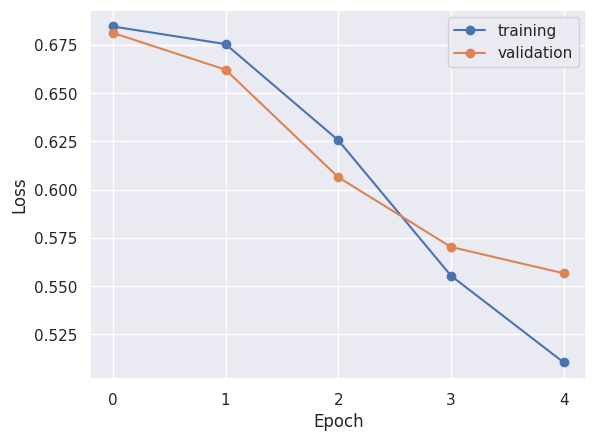

In [ ]:
model = build_onehot_model() # LR-A

# Fit the model.
history = model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_data=(X_validate_one_hot, Y_validate), # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.

history = pd.DataFrame(history.history)
plot_history(history)

In [ ]:
# calculating F1 score on validation data
validate_preds_raw = model.predict(X_validate_one_hot)
validate_preds = (validate_preds_raw >= 0.5).astype(int)

print(calculate_f1_score(Y_validate, validate_preds))

24/24 [==============================] - 0s 5ms/step
0.6413793103448276


##### Predictions on Test Data

In [ ]:
## Making predictions on test data
X_test = test_df["text"]

X_test_vectorized = vectorize_layer(X_test)
X_test_padded = pad_data(X_test_vectorized, max_length=25)
X_test_reduced = limit_vocab(X_test_padded, max_token_id=1500)
X_test_one_hot = tf.keras.utils.to_categorical(X_test_reduced, num_classes=1500)

test_preds_raw = model.predict(X_test_one_hot)
test_preds = (test_preds_raw >= 0.6).astype(int) #threshold = 0.6

result = test_df["id"]
result = pd.DataFrame(result)
result["target"] = test_preds
display(result)

# Writing predictions to csv file.
result.to_csv('submission.csv', index=False)

102/102 [==============================] - 1s 6ms/step


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


#####Confusion Matrix for Error Analysis

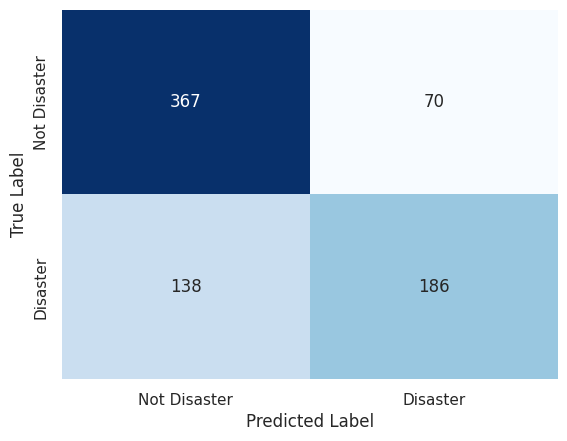

In [ ]:
# Build a confusion matrix from the predictions validation data

confusion_matrix = tf.math.confusion_matrix(labels=Y_validate, predictions=validate_preds)
ax = sns.heatmap(confusion_matrix, annot=True, cmap="Blues", cbar=False, fmt='d', xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

We can see that the true negative is 367, the true positive is 186, the false positive is 70 and the false negative is 138.

#####Examination of Model Errors
From analysing the error metrics or confusion matrix, we can notice that the model predicted more disaster as non-disaster(FN) than it predicted more non-disaster as disaster(FP).

We can then check for miscalculation analysis by printing a few input tweets that were false negative(FN) and those that were true positive(TP) and examining the difference between these inputs.

In [ ]:
#Code to print a few example that are FN and TP from the model predictions(all printed results should have a true value of positive)
#printing only 20 examples each

print("These are those that are FN\n")
count = 0
for i in range(len(Y_validate)):
  if not validate_preds[i] and Y_validate[i]:
    print(X_validate[i])
    count += 1
  if count == 20:
    break

print("\n\nThese are those that are TP\n")
count = 0
for i in range(len(Y_validate)):
  if validate_preds[i] and Y_validate[i]:
    print(X_validate[i])
    count += 1
  if count == 20:
    break

These are those that are FN

#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/nGKrZPza45 #prebreak #best
Hiroshima survivors fight nuclear industry in Brazil ÛÒ video http://t.co/E7SHtYLbnL
Nearly had a heart attack just now; loud bang against window next to meÛ_turns out it was two birds flying into the glass.
Sooo police dispatch said there was a person threatening to shoot up the Walmart on Rutherford &amp; they had to evacuate
Û÷Good SamaritansÛª shot in horror hijacking http://t.co/V5yUUALoqw #263Chat #Twimbos ZimpapersViews
California is battling its scariest 2015 wildfire so far. http://t.co/Lec1vmS7x2
Rand Paul's Debate Strategy 'demolish Some other bad ideas out there or point out maybe that there are some em... http://t.co/qzdqRBr4Lh
If you did a cannon ball into the ocean then Japan would evacuate.
The 46 returned refugees - what were they fleeing from &amp; how will the Vietnamese Govt treat them now they are 

####Feed Forward Neural Network with Embeddings

In [ ]:
X_train_padded = pad_data(X_train_vectorized, max_length=40)
X_validate_padded = pad_data(X_validate_vectorized, max_length=40)

X_train_reduced = limit_vocab(X_train_padded, max_token_id=7500)
X_validate_reduced = limit_vocab(X_validate_padded, max_token_id=7500)

In [ ]:
def build_embeddings_model(vocab_size=7500,
                           sequence_length=40,
                           embedding_dim=125):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  # This layer averages over the first dimension of the input by default.
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dense(
      units=128,
      activation='relu'
  ))
  model.add(tf.keras.layers.Dense(
      units=10,
      activation='relu'
  ))
  model.add(tf.keras.layers.Dense(
      units=18,
      activation='sigmoid'
  ))
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

Epoch 1/5
108/108 [==============================] - 2s 5ms/step - loss: 0.6834 - accuracy: 0.5699 - val_loss: 0.6807 - val_accuracy: 0.5742
Epoch 2/5
108/108 [==============================] - 0s 3ms/step - loss: 0.6645 - accuracy: 0.5863 - val_loss: 0.6204 - val_accuracy: 0.7162
Epoch 3/5
108/108 [==============================] - 0s 3ms/step - loss: 0.5174 - accuracy: 0.8015 - val_loss: 0.4848 - val_accuracy: 0.7950
Epoch 4/5
108/108 [==============================] - 0s 3ms/step - loss: 0.3893 - accuracy: 0.8421 - val_loss: 0.4582 - val_accuracy: 0.7989
Epoch 5/5
108/108 [==============================] - 0s 3ms/step - loss: 0.3292 - accuracy: 0.8710 - val_loss: 0.4549 - val_accuracy: 0.8095


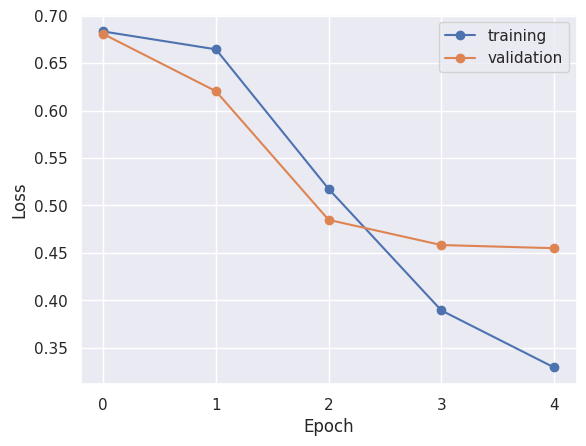

In [ ]:
model = build_embeddings_model(vocab_size=7500,
                               sequence_length=40,
                              #  embedding_dim=125)
                               embedding_dim=3)

history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  # epochs=3,             # number of passes through the training data
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_data=(X_validate_reduced, Y_validate), # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )
history = pd.DataFrame(history.history)
plot_history(history)

In [ ]:
# calculating F1 score on validation data
new_validate_preds_raw = model.predict(X_validate_reduced)
new_validate_preds = (new_validate_preds_raw >= 0.6).astype(int)

print(calculate_f1_score(Y_validate, new_validate_preds))

24/24 [==============================] - 0s 1ms/step
0.7554806070826307


##### Predictions on Test Data

In [ ]:
## Making predictions on test data
X_test = test_df["text"]

X_test_vectorized = vectorize_layer(X_test)
X_test_padded = pad_data(X_test_vectorized, max_length=40)
X_test_reduced = limit_vocab(X_test_padded, max_token_id=7500)

test_preds_raw = model.predict(X_test_reduced)
test_preds = (test_preds_raw >= 0.6).astype(int) #threshold = 0.6

result = test_df["id"]
result = pd.DataFrame(result)
result["target"] = test_preds
display(result)

# Writing predictions to csv file.
result.to_csv('submissionFinal.csv', index=False)

102/102 [==============================] - 0s 2ms/step


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


#####Confusion Matrix for Error Analysis


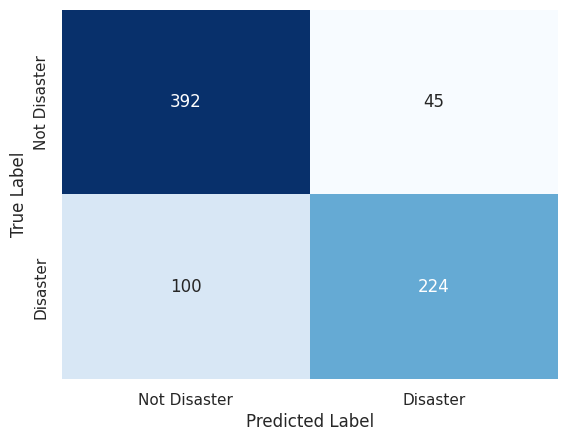

In [ ]:
# Build a confusion matrix from the predictions validation data

confusion_matrix = tf.math.confusion_matrix(labels=Y_validate, predictions=new_validate_preds)
ax = sns.heatmap(confusion_matrix, annot=True, cmap="Blues", cbar=False, fmt='d', xticklabels=["Not Disaster", "Disaster"], yticklabels=["Not Disaster", "Disaster"])
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

We can see that the true negative is 392, the true positive is 224, the false positive is 45 and the false negative is 100. We can see that this model is an improvement from the last ones as both true positve and true negative increased, while false negative and false positive decreased.

#####Examination of Model Errors
Just like in LR-A without embeddings, we can start with analyzing the error metrics or confusion matrix and noticing that the model predicts more disaster as non-disaster(FN) than it predicts more non-disaster as disaster(FP).

We can then check for miscalculation analysis by printing a few input tweets that were false negative(FN) and those that were true positive(TP) and examinng the difference between these inputs.

In [ ]:
#Code to print a few example that are FN and TP from the model predictions(all printed results should have a true value of positive)
#printing only 20 examples each

print("These are those that are FN\n")
count = 0
for i in range(len(Y_validate)):
  if not new_validate_preds[i] and Y_validate[i]:
    print(X_validate[i])
    count += 1
  if count == 20:
    break

print("\n\nThese are those that are TP\n")
count = 0
for i in range(len(Y_validate)):
  if new_validate_preds[i] and Y_validate[i]:
    print(X_validate[i])
    count += 1
  if count == 20:
    break

These are those that are FN

#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/nGKrZPza45 #prebreak #best
Nearly had a heart attack just now; loud bang against window next to meÛ_turns out it was two birds flying into the glass.
@blairmcdougall and when will you be commenting on Ian Taylor's dealings with mass - murderer Arkan?
@SenateMajLdr let's try to do our best to prevent another outbreak of violence by talking to each other both the people and the politics
Rand Paul's Debate Strategy 'demolish Some other bad ideas out there or point out maybe that there are some em... http://t.co/qzdqRBr4Lh
@_gaabyx we got purple activist I thought it was a drought
If you did a cannon ball into the ocean then Japan would evacuate.
@PyrBliss ah I remember those days. In a snowstorm too.
We have overrun a Natural Disaster Survival server!
@new_hart2010 #mudslide... nuff said #GBBO
Aashiqui Actress Anu Aggarwal On Her Near-Fatal Accident h

1. The first notable difference is that almost all TP examples have links in them while only a fifth of those that are FP have http links.
2. Also, we can see that almost every single tweet that is FN has the @ sign while only one TP tweet has an @ sign.


To address the "@" symbol concern, we can consider making it a part of the vocabulary, and it becomes a learned feature for the model, rather than discarding it with other non-alphanumeric symbols in the text-preprocessing stage of the model development.

## Final Results



|Model|Loss|Accuracy|Validation Loss|Validation Accuracy|F1 Score (Validation)|F1 Score (Test)
|-|-|-|-|-|-|-|
|Baseline|N/A|N/A|N/A|N/A|0.6582278481012659|0.63499|
|FFNN with One-hot encodings|0.5105|0.7626|0.5567|0.7267|0.6413793103448276|0.72356|
|FFNN with Embeddings|0.3292|0.8710|0.4549|0.8095|0.7554806070826307|0.80723|

##Conclusion

We were able to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t using FFNN with one-hot encodings and with embeddings. We also had data analyses where we analyzed the input and output and visualized data in both tables and histograms. We were also able to use a confusion matrix to visualize the model's performance. The table above has our baseline and model values for the losses, accuracies and f1 scores on both test and validation data.